In [1]:
# ALGORYTM Z "Approximation of piecewise Hölder functions from inexact information"

# PARAMETRY ALGORYTMU:
# h = T/m, gdzie m >= 2r + 1   <--- initial resolution of the mesh
# 0 < w < (r + 1) * h

In [2]:
# Kroki algorytmu:
# 1. aproksymacja punktu osobliwego s_f
#   1a. siatka regularna (o długości h) oraz różnice dzielne użyte są do lokalizacji s_f na przedziale [u_1, v_1] (o długości (r+1) * h)
#   1b. zawęzenie przedziałów z 1a do [u_2, v_2] przy użyciu wielomianów ekstrpolacyjnych p_neg i p_pos
#   1c. wyprodukowanie przedziału [u_3, v_3] zawierającego się (lub równego) [u_2, v_2], w którym różnica |p_pos - p_neg| jest nierosnąca na [u_3, ksi] i niemalejąca na [ksi, v_3], gdzie ksi jest finalną aproksymacją s_f
# 2.

In [2]:
import numpy as np

In [1]:
print(np.finfo(np.longdouble))


NameError: name 'np' is not defined

In [6]:
T = 2 * np.pi + 0.5

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x - np.pi)
    if np.pi <= x <= 2 * np.pi + 0.5:
        return np.sin(x - np.pi - 0.5)


In [7]:
T = 3 * np.pi

def f(x):
    if 0 <= x < np.pi:
        return np.sin(x)
    if np.pi <= x <= 3 * np.pi:
        return np.sin(x - np.pi)

In [8]:
from math import fsum

def prod(i, r, t, j):
    product = 1.0
    for k in range(i, i+r+1):
        if k == j:
            continue
        product *= 1 / (t[k] - t[j])
    return product


def d_noisy2(i, r, t, y):
    """t : array of data points t_i, ... , t_{i+r+1}
       y : array of y_j = f(t_j) + e_j  """
    t.astype('float64')
    y.astype('float64')

    array = [y[j] * prod(i, r, t, j) for j in range(i, i+r+1)]
    # print(array)
    return fsum(array)
    # return np.sum(np.sort([y[j] * prod(i, r, t, j) for j in range(i, i+r+1)]))

In [9]:
def d_noisy(i, r, t, y):
    """t : array of data points t_i, ... , t_{i+r+1}
       y : array of y_j = f(t_j) + e_j  """
    t.astype('float64')
    y.astype('float64')

    sum = np.float64(0.0)
    for j in range(i, i+r+1):

        product = 1.0
        for k in range(i, i+r+1):
            if k == j:
                continue
            product *= 1 / (t[k] - t[j])

        sum += y[j] * product

    return sum

In [10]:
delta = 10e-4
r = 2
m = 100

In [11]:
# Step 0 (initialization of algorithm's constants and function evaluations)
h = T / m
w = -1.0 * np.random.uniform(-(r + 1) * h, 0) # multiply by -1 because we need interval (0, (r + 1) * h]
# print("h = {}".format(h))
# for i in range(0, m + 1):
#     print("t_{} = {}".format(i, i*h))
t = np.linspace(0, T, m+1, dtype='float64') # czyli mamy m+1 wezlów postaci t[0], ... , t[m]
e = np.random.uniform(-delta, delta, m+1)
y = np.array([f(t[j]) + e[j] for j in range(0, m+1)])

In [12]:
np.set_printoptions(precision = 8, suppress=True)
print(t)
print(e)
print(y)

[0.         0.09424778 0.18849556 0.28274334 0.37699112 0.4712389
 0.56548668 0.65973446 0.75398224 0.84823002 0.9424778  1.03672558
 1.13097336 1.22522113 1.31946891 1.41371669 1.50796447 1.60221225
 1.69646003 1.79070781 1.88495559 1.97920337 2.07345115 2.16769893
 2.26194671 2.35619449 2.45044227 2.54469005 2.63893783 2.73318561
 2.82743339 2.92168117 3.01592895 3.11017673 3.20442451 3.29867229
 3.39292007 3.48716785 3.58141563 3.6756634  3.76991118 3.86415896
 3.95840674 4.05265452 4.1469023  4.24115008 4.33539786 4.42964564
 4.52389342 4.6181412  4.71238898 4.80663676 4.90088454 4.99513232
 5.0893801  5.18362788 5.27787566 5.37212344 5.46637122 5.560619
 5.65486678 5.74911456 5.84336234 5.93761012 6.03185789 6.12610567
 6.22035345 6.31460123 6.40884901 6.50309679 6.59734457 6.69159235
 6.78584013 6.88008791 6.97433569 7.06858347 7.16283125 7.25707903
 7.35132681 7.44557459 7.53982237 7.63407015 7.72831793 7.82256571
 7.91681349 8.01106127 8.10530905 8.19955683 8.29380461 8.3880523

In [13]:
# Step 1
i_max = np.argmax([d_noisy(i, r, t, y) for i in range(0, m-r)]) # innaczej liczone roznice dzielone
u_1 = t[i_max]
v_1 = t[i_max + r +1]
print("i_max = {}  u_1 = {}  v_1 = {}".format(i_max, t[i_max], t[i_max + r +1]))

i_max = 32  u_1 = 3.015928947446201  v_1 = 3.2986722862692828


In [14]:
# Step 1
i_max = np.argmax([d_noisy2(i, r, t, y) for i in range(0, m-r)])
u_1 = t[i_max]
v_1 = t[i_max + r +1]
print("i_max = {}  u_1 = {}  v _1 = {}".format(i_max, t[i_max], t[i_max + r +1]))

i_max = 32  u_1 = 3.015928947446201  v _1 = 3.2986722862692828


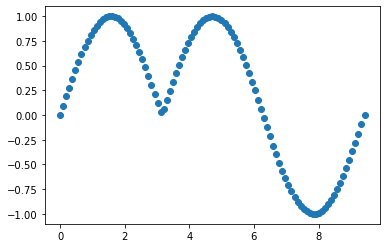

In [15]:
import matplotlib.pyplot as plt

plt.scatter(t,y)

In [16]:
from scipy import interpolate

In [17]:
# Step 2
p_neg = interpolate.interp1d(
    t[i_max - r:i_max + 1],
    y[i_max - r:i_max + 1],
    fill_value="extrapolate"
)
p_pos = interpolate.interp1d(
    t[i_max + r + 1: i_max + 2 * r + 1 + 1],
    y[i_max + r + 1: i_max + 2 * r + 1 + 1],
    fill_value="extrapolate"
)


In [18]:
# Step 2 continued
u = u_1
v = v_1

while v - u > w:
    z = np.array([u + j * (v - u) / (r + 2) for j in range(1, r + 2)])
    dif = np.abs(p_pos(z) - p_neg(z))
    j_max = np.argmax(dif)

    # tu chyba nie powinno byc bezposrednio f tylko f_noisy = f() + e
    if np.abs(f(z[j_max]) - p_neg(z[j_max])) <= np.abs(f(z[j_max]) - p_pos(z[j_max])):
        u = z[j_max]
    else:
        v = z[j_max]

u_2 = u
v_2 = v

In [19]:
print(u_1, v_1)
print(u_2, v_2)

3.015928947446201 3.2986722862692828
3.1320499748244046 3.147972245994224


In [20]:
from scipy.optimize import minimize_scalar

In [21]:
def fun(x):
    return -1 * np.abs(p_neg(x) - p_pos(x))

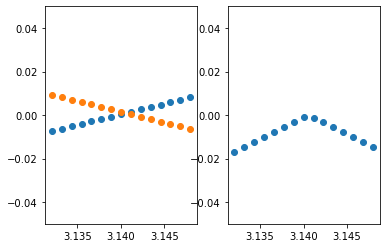

In [40]:
interval = np.linspace(u_2, v_2, num=15)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(interval, p_pos(interval))
ax[0].scatter(interval, p_neg(interval))

ax[1].scatter(interval, fun(interval))

plt.setp(ax, ylim=(-0.05, 0.05))
plt.show()

result = minimize_scalar(fun=fun, bracket=(u,v))

print("if success = {}  z_max = {}".format(result.success, result.x))

In [23]:
# Step 3
u = u_2
v = v_2


z_max = [0.0]   # it list only because we need to modify it inside of function (we cannot modify number)
while True:
    result = minimize_scalar(fun=fun, bracket=(u,v))
    if result.success == False:
        break
    
    z_max = result.x
    if np.abs(f(z_max) - p_neg(z_max)) <= np.abs(f(z_max) - p_pos(z_max)):
        u = z
    else:
        v = z

u_3 = u
v_3 = v

C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2527: RuntimeWarning: overflow encountered in double_scalars
  if (w - xc) * (xb - w) > 0.0:
C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2547: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(xc - w) > 0.0:
C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2543: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2522: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2515: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
C:\Users\tczyz\Anaconda3\envs\myenv\lib\site-packages\scipy\optimize\optimize.py:2516: RuntimeWarn

In [24]:
print(u_1, v_1)
print(u_2, v_2)
print(u_3, v_3)

3.015928947446201 3.2986722862692828
3.1320499748244046 3.147972245994224
3.1320499748244046 3.147972245994224


In [25]:
# Final approximation (i use custom mesh to find argmin)
mesh = np.arange(u_1, v_1, step=0.0005)
x_array = [np.abs(p_pos(k) - p_neg(k)) for k in mesh]
ksi = mesh[np.argmin(x_array)] # ksi is on x-asix

In [26]:
print(ksi)

3.140428947446243


In [27]:
# print(z)
# print(t[i_max:i_max + r + 1])

# Final approximation    <--- wedlug mnie to jest najlogiczniejsze, gdyz dla tych wezłow juz wczesniej liczylismy wartosci funkcji(możnaby nawet gdzies je zapisac i uzyc jeszcze raz zeby nie narazac sie na powtórne liczenie w arytmetyce fl, jednak z drugiej strony tych ovliczonych wartości fun, nie jest duzo)
# x = [np.abs(p_pos(k) - p_neg(k)) for k in z]
# ksi = np.argmin(x)
# print(x)
# print(ksi)

# Final approximation
# x = [np.abs(p_pos(k) - p_neg(k)) for k in t[i_max:i_max + r + 1]]
# ksi = np.argmin(x)
# print(x)
# print(ksi)

In [28]:
# mamy "przedziały" na osi x-ów:
# t[0],...,t[i_max-1]      u_1,...,mesh[ksi]   mesh[ksi],...,v_1   t[i_max + r + 1 + 1],...,T
# u_1 = t[i_max]   v_1 = t[i_max + r + 1]

# finding closest value to ksi in orginal mesh
k = 0
while ksi > t[k]:
    k += 1

k = k if np.abs(ksi - t[k]) < np.abs(ksi - t[k+1]) else k+1

x_array = np.append(t[:i_max-1], t[i_max:k], )

In [29]:
# Final interpolating polynomial

polynomial1 = interpolate.interp1d(
            t[:i_max + 1],
            y[:i_max + 1])

polynomial2 = interpolate.interp1d(
            t[i_max + r + 1:],
            y[i_max + r + 1:])

def final_polynomial(x):
    if (t[0] <= x).all() and (x < u_1).all():
        return polynomial1(x)
    if (u_1 <= x).all() and (x < ksi).all():
        return p_neg(x)
    if (ksi <= x).all() and (x < v_1).all():
        return p_pos(x)
    if (v_1 <= x).all() and (x <= t[m]).all():
        return polynomial2(x)

In [30]:
values = []
for x in t:
    values += [final_polynomial(x)]

values = np.array(values)

In [31]:
t.shape

(101,)

In [32]:
values.shape

(101,)

In [33]:
print(values)

[-0.00013188  0.09316689  0.18794926  0.27804767  0.36905589  0.45379715
  0.5359593   0.61372395  0.68453582  0.75004947  0.8087013   0.85978167
  0.90524956  0.94039564  0.96895164  0.98821099  0.99851336  0.99920757
  0.99213323  0.97691476  0.95072026  0.91804425  0.87671836  0.82721001
  0.77051748  0.70624361  0.63770561  0.56263171  0.48103993  0.3969371
  0.30808549  0.21769596  0.12437662  0.03105729  0.06340965  0.1555862
  0.24776275  0.33811744  0.4251148   0.5090873   0.58826724  0.66061272
  0.72922976  0.78946914  0.84335969  0.89165764  0.9297905   0.95969044
  0.98164743  0.99647618  0.99912001  0.99456878  0.98240531  0.95999329
  0.93024818  0.89150759  0.84386345  0.79092198  0.72985281  0.66091199
  0.58834256  0.50813647  0.4266934   0.33777167  0.24842585  0.15654876
  0.06200126 -0.03185021 -0.1259763  -0.21721368 -0.3093981  -0.39711387
 -0.48184067 -0.56227741 -0.63812196 -0.70792822 -0.77103899 -0.82650929
 -0.87714785 -0.91816398 -0.95016486 -0.97544701 -0.9

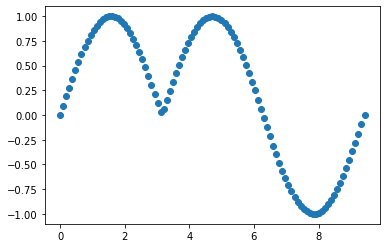

In [34]:
plt.scatter(t,values)

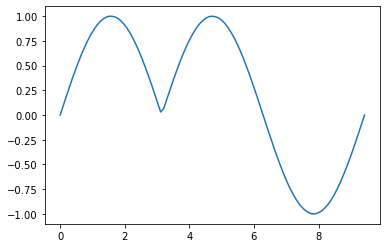

In [35]:
plt.plot(t,values)
plt.show()

In [36]:
# here will be error plot

In [37]:
def error_of_approximation(x):
    return np.abs(f(x) - final_polynomial(x))

In [38]:
error_of_approximation(1.72)

0.0005576043736579273